<a href="https://colab.research.google.com/github/JohnPaul0403/ai_notebooks/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder Research

In this notebook we will experiment and use Convulusional Autoencoders for image denoising.

## Dataset

As a first experiment we will use the Fashion mnist dataset to train the model. The fashion mnist dataset will help us to find more complex patterns in our data, making this problem more complex and better to delovope in long scale experiment

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [3]:
# Getting GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Getting datset and using transforms to convert inot tensor
dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.3MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 174kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.19MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.19MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



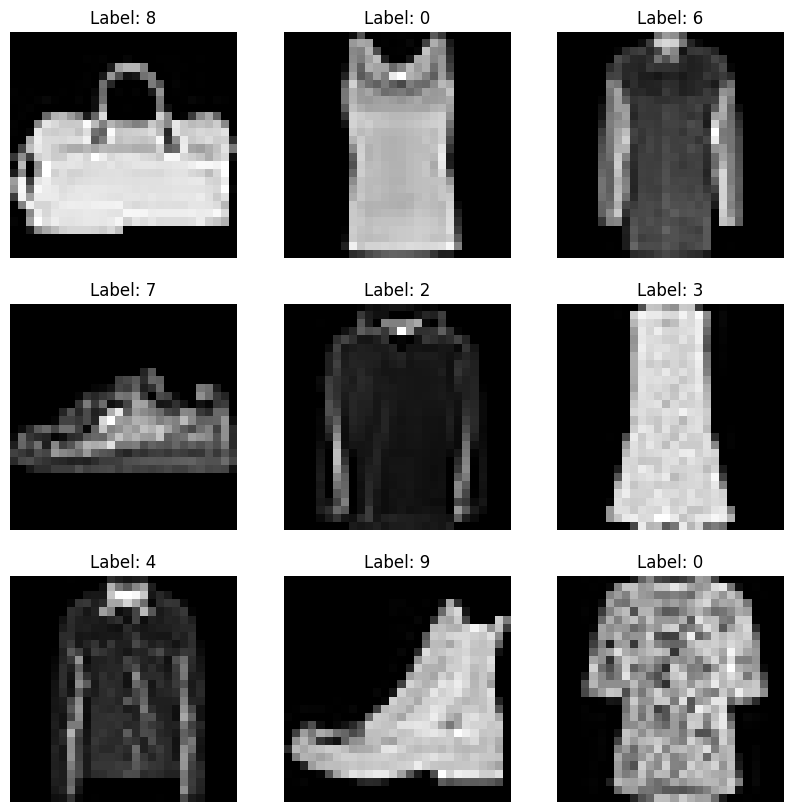

In [5]:
# Visualize 9 random images from dataset
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    idx = np.random.randint(0, len(dataset))
    img, label = dataset[idx]
    axs[i//3, i%3].imshow(img.squeeze(), cmap='gray')
    axs[i//3, i%3].set_title(f'Label: {label}')
    axs[i//3, i%3].axis('off')
plt.show()

In [6]:
#Function that will add noise to the images
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)

In [7]:
# Function that displays the images with and without noise

def display_images(images, noisy_images):
    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    axes[0, 0].imshow(images[0].squeeze(), cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 1].imshow(noisy_images[0].squeeze(), cmap='gray')
    axes[0, 1].set_title('Noisy Image')
    axes[1, 0].imshow(images[1].squeeze(), cmap='gray')
    axes[1, 0].set_title('Original Image')
    axes[1, 1].imshow(noisy_images[1].squeeze(), cmap='gray')
    axes[1, 1].set_title('Noisy Image')
    axes[2, 0].imshow(images[2].squeeze(), cmap='gray')
    axes[2, 0].set_title('Original Image')
    axes[2, 1].imshow(noisy_images[2].squeeze(), cmap='gray')
    axes[2, 1].set_title('Noisy Image')
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

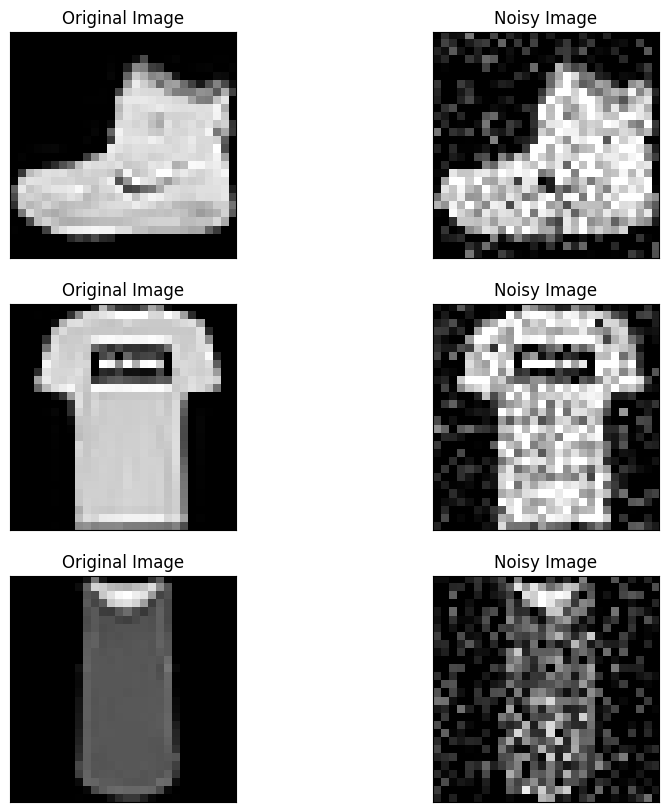

In [8]:
noise_transform = transforms.Compose([
    transforms.Lambda(lambda x: add_noise(x)),
])

# Visualizing images
images = [dataset[i][0] for i in range(3)]
noisy_images = [noise_transform(img) for img in images]
display_images(images, noisy_images)

In [9]:
x = []
y = []
for i in range(len(dataset)):
    img, label = dataset[i]
    noisy_img = noise_transform(img)
    x.append(noisy_img)
    y.append(img)


train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
train_x = torch.stack(train_x)
train_y = torch.stack(train_y)
test_x = torch.stack(test_x)
test_y = torch.stack(test_y)

In [11]:
train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

In [37]:
from math import pi
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
pic2pic_dataset = torch.utils.data.TensorDataset(train_y, train_y)
pic2pic_test_dataset = torch.utils.data.TensorDataset(test_y, test_y)

In [38]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
pic2pic_loader = DataLoader(pic2pic_dataset, batch_size=64, shuffle=True)
pic2pic_test_loader = DataLoader(pic2pic_test_dataset, batch_size=64, shuffle=False)

# Model (Autoencoder)

Autoencoders are a type of encoder which uses unsurpervised learning to learn patterns from data. The idea is to create from a given image, compressed and decrompresses it.

In [39]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Encoder, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn_2 = nn.BatchNorm2d(out_channels)
        self.relu_2 = nn.ReLU()
        self.maxpool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.relu_2(x)
        x = self.maxpool_2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Decoder, self).__init__()
        # Change in_channels to match the encoder's output channels
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv_2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn_2 = nn.BatchNorm2d(out_channels)
        self.relu_2 = nn.ReLU()
        self.upsample_2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv_3 = nn.Conv2d(out_channels, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.upsample(x)
        # Add the rest of the decoder layers for upsampling and reconstruction
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.relu_2(x)
        x = self.upsample_2(x)
        # Add a final convolutional layer to get the output to 1 channel
        x = self.conv_3(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Change in_channels to match the encoder's output channels
        self.decoder = Decoder(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [40]:
torch.manual_seed(42)

model = Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

Autoencoder(
  (encoder): Encoder(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_2): ReLU()
    (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (conv): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (upsample): Upsample(scale_factor=2.0, mode='nearest')
    (conv_2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn_2): BatchNorm2d(32, eps=1e

In [41]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        train_acc += (output == data).float().mean()

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader)
    return train_loss, train_acc

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data)
            test_loss += loss.item() * data.size(0)
            test_acc += (output == data).float().mean()

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_acc / len(test_loader)
    return test_loss, test_acc

In [42]:
from tqdm.auto import tqdm
torch.manual_seed(42)

num_epochs = 10
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in tqdm(range(num_epochs)):
    train_loss, train_acc = train(model, pic2pic_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, pic2pic_test_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.0193, Train Acc: 0.0000, Test Loss: 0.0092, Test Acc: 0.0000
Epoch 2/10, Train Loss: 0.0081, Train Acc: 0.0000, Test Loss: 0.0075, Test Acc: 0.0000
Epoch 3/10, Train Loss: 0.0068, Train Acc: 0.0000, Test Loss: 0.0065, Test Acc: 0.0000
Epoch 4/10, Train Loss: 0.0061, Train Acc: 0.0000, Test Loss: 0.0050, Test Acc: 0.0000
Epoch 5/10, Train Loss: 0.0056, Train Acc: 0.0000, Test Loss: 0.0047, Test Acc: 0.0000
Epoch 6/10, Train Loss: 0.0051, Train Acc: 0.0000, Test Loss: 0.0050, Test Acc: 0.0000
Epoch 7/10, Train Loss: 0.0050, Train Acc: 0.0000, Test Loss: 0.0041, Test Acc: 0.0000
Epoch 8/10, Train Loss: 0.0047, Train Acc: 0.0000, Test Loss: 0.0043, Test Acc: 0.0000
Epoch 9/10, Train Loss: 0.0044, Train Acc: 0.0000, Test Loss: 0.0040, Test Acc: 0.0000
Epoch 10/10, Train Loss: 0.0042, Train Acc: 0.0000, Test Loss: 0.0053, Test Acc: 0.0000


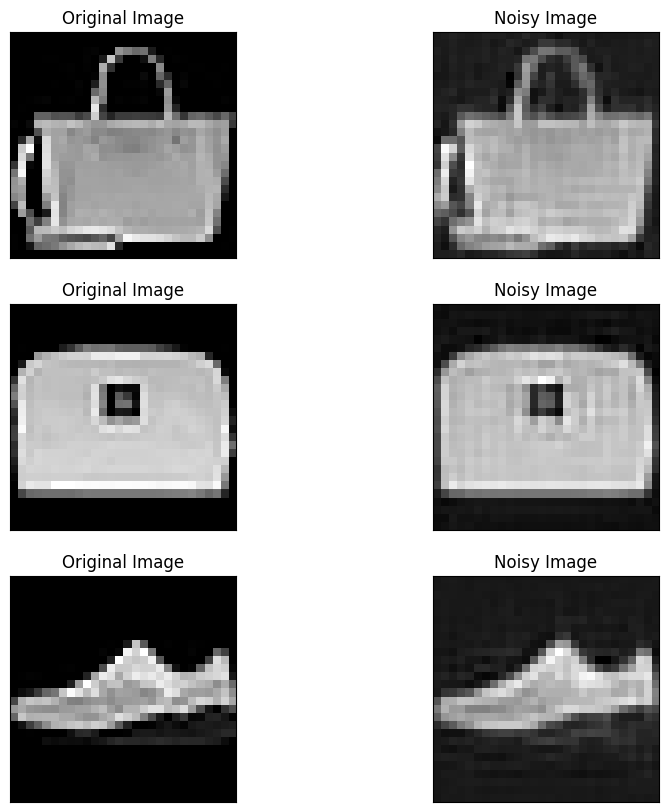

In [44]:
#Visualazing the results

def predict(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
    return output

y_pred = predict(model, test_y)
y_pred = y_pred.cpu().numpy() # move to cpu before convertion
# y_pred = np.argmax(y_pred, axis=1) #Removed because is not a classification problem
y_true = test_y.cpu().numpy() # move to cpu before convertion
# y_true = np.argmax(y_true, axis=1) #Removed because is not a classification problem

images_test = [test_y[i].cpu().numpy() for i in range(3)]
predictions = [y_pred[i] for i in range(3)]
display_images(images_test, predictions)

In [45]:
# Trying different EPOCHS

torch.manual_seed(42)

num_epochs = 50
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in tqdm(range(10, num_epochs)):
    train_loss, train_acc = train(model, pic2pic_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, pic2pic_test_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50, Train Loss: 0.0041, Train Acc: 0.0000, Test Loss: 0.0043, Test Acc: 0.0000
Epoch 12/50, Train Loss: 0.0040, Train Acc: 0.0000, Test Loss: 0.0040, Test Acc: 0.0000
Epoch 13/50, Train Loss: 0.0039, Train Acc: 0.0000, Test Loss: 0.0043, Test Acc: 0.0000
Epoch 14/50, Train Loss: 0.0038, Train Acc: 0.0000, Test Loss: 0.0039, Test Acc: 0.0000
Epoch 15/50, Train Loss: 0.0038, Train Acc: 0.0000, Test Loss: 0.0033, Test Acc: 0.0000
Epoch 16/50, Train Loss: 0.0036, Train Acc: 0.0000, Test Loss: 0.0033, Test Acc: 0.0000
Epoch 17/50, Train Loss: 0.0037, Train Acc: 0.0000, Test Loss: 0.0035, Test Acc: 0.0000
Epoch 18/50, Train Loss: 0.0035, Train Acc: 0.0000, Test Loss: 0.0035, Test Acc: 0.0000
Epoch 19/50, Train Loss: 0.0034, Train Acc: 0.0000, Test Loss: 0.0033, Test Acc: 0.0000
Epoch 20/50, Train Loss: 0.0033, Train Acc: 0.0000, Test Loss: 0.0037, Test Acc: 0.0000
Epoch 21/50, Train Loss: 0.0033, Train Acc: 0.0000, Test Loss: 0.0040, Test Acc: 0.0000
Epoch 22/50, Train Loss: 0.0033,

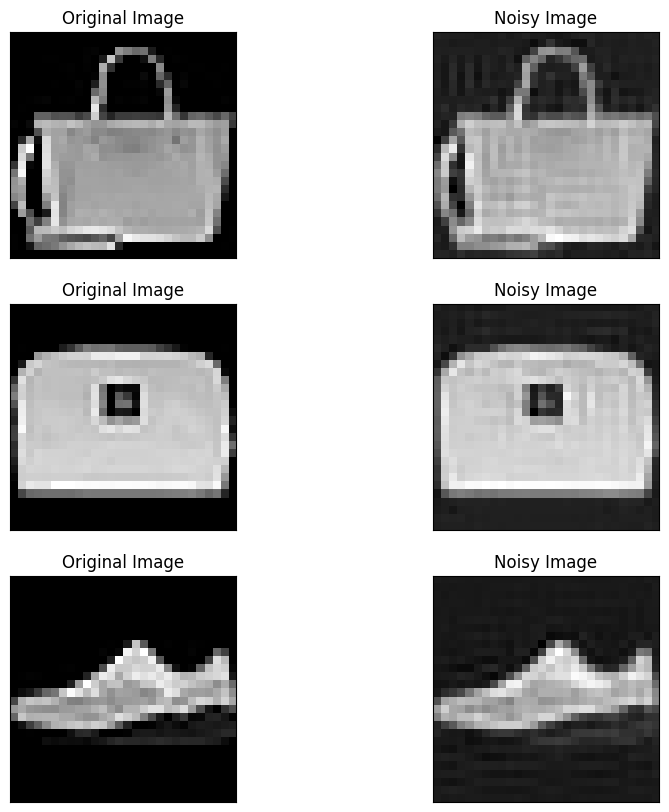

In [46]:
#Visualazing the results

def predict(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
    return output

y_pred = predict(model, test_y)
y_pred = y_pred.cpu().numpy() # move to cpu before convertion
# y_pred = np.argmax(y_pred, axis=1) #Removed because is not a classification problem
y_true = test_y.cpu().numpy() # move to cpu before convertion
# y_true = np.argmax(y_true, axis=1) #Removed because is not a classification problem

images_test = [test_y[i].cpu().numpy() for i in range(3)]
predictions = [y_pred[i] for i in range(3)]
display_images(images_test, predictions)

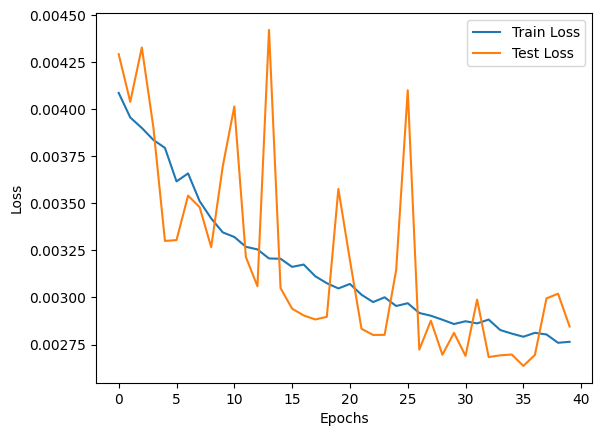

In [47]:
# Visualazing train ans test loss

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Train part 2

Now we will retrain the autoencoder so it will learn how to denoise the given image.

In [48]:
# Retraining the autoencoder to denoise images

torch.manual_seed(42)

num_epochs = 100
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in tqdm(range(num_epochs)):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.0152, Train Acc: 0.0000, Test Loss: 0.0148, Test Acc: 0.0000
Epoch 2/100, Train Loss: 0.0146, Train Acc: 0.0000, Test Loss: 0.0143, Test Acc: 0.0000
Epoch 3/100, Train Loss: 0.0143, Train Acc: 0.0000, Test Loss: 0.0140, Test Acc: 0.0000
Epoch 4/100, Train Loss: 0.0141, Train Acc: 0.0000, Test Loss: 0.0139, Test Acc: 0.0000
Epoch 5/100, Train Loss: 0.0139, Train Acc: 0.0000, Test Loss: 0.0139, Test Acc: 0.0000
Epoch 6/100, Train Loss: 0.0138, Train Acc: 0.0000, Test Loss: 0.0139, Test Acc: 0.0000
Epoch 7/100, Train Loss: 0.0137, Train Acc: 0.0000, Test Loss: 0.0136, Test Acc: 0.0000
Epoch 8/100, Train Loss: 0.0135, Train Acc: 0.0000, Test Loss: 0.0134, Test Acc: 0.0000
Epoch 9/100, Train Loss: 0.0134, Train Acc: 0.0000, Test Loss: 0.0133, Test Acc: 0.0000
Epoch 10/100, Train Loss: 0.0133, Train Acc: 0.0000, Test Loss: 0.0134, Test Acc: 0.0000
Epoch 11/100, Train Loss: 0.0132, Train Acc: 0.0000, Test Loss: 0.0134, Test Acc: 0.0000
Epoch 12/100, Train Loss: 0.01

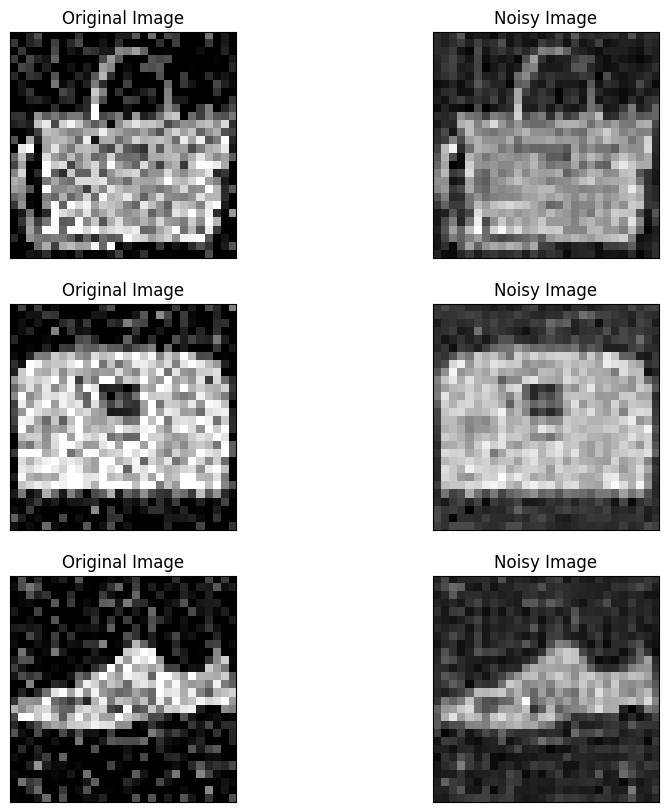

In [49]:
# Visualazing the results

y_pred = predict(model, test_x)
y_pred = y_pred.cpu().numpy() # move to cpu before convertion
# y_pred = np.argmax(y_pred, axis=1) #Removed because is not a classification
y_true = test_x.cpu().numpy() # move to cpu before convertion
# y_true = np.argmax(y_true, axis=1) #Removed because is not a classification

images_test = [test_x[i].cpu().numpy() for i in range(3)]
predictions = [y_pred[i] for i in range(3)]
display_images(images_test, predictions)

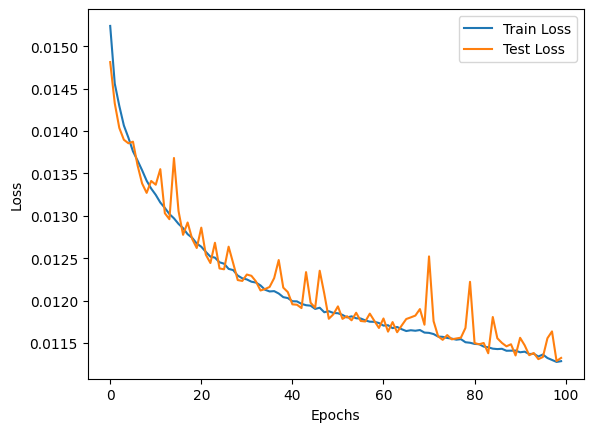

In [50]:
# Getting train and test loss

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()